In [1]:
import numpy as np
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from scipy.stats import gamma
from scipy.stats import norm
import fixed_income_derivatives as fid 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

## **Problem 1**

In [2]:
r0, a, b, sigma = 0.038, 1.2, 0.07, 0.04
T_max = 10
alpha = 0.5
M = int(T_max/alpha) + 1
T = np.array([i*alpha for i in range(0,M)])
p = fid.zcb_price_vasicek(r0,a,b,sigma,T)
R = fid.spot_rate_vasicek(r0,a,b,sigma,T)
f = fid.forward_rate_vasicek(r0,a,b,sigma,T)
f_10m = fid.zcb_to_forward_rates(T,p,horizon = 1)

#### ai) - aii) 
Fitting the Vasicek model to data and demonstrating that the model fits the estimated parameter values:

In [3]:
param_0 = 0.038, 1.2, 0.07, 0.04
result = minimize(fid.fit_vasicek_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit including sigma: {result.x}. SSE of the fit: {result.fun}")

Parameters from the fit including sigma: [0.038 1.2   0.07  0.04 ]. SSE of the fit: 0.0


In [4]:
param_0 = 0.038, 1.2, 0.07
result = minimize(fid.fit_vasicek_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R,T),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit omitting sigma: {result.x}. SSE of the fit: {result.fun}")

Parameters from the fit omitting sigma: [0.038 1.2   0.07 ]. SSE of the fit: 0.0


From these outputs it appears that all the parameters from the fit equals their respective inital values. Thus, the Vasicek model has a perfect fit with a SSE of 0. However, a perfect fit might not always be ideal and could raise concerns such as overfitting or a lack of generalizability in the data.

#### bi)

In [5]:
idx_n, idx_N = 0, 12
S_swap = 0
for idx in range(idx_n+1,idx_N+1):
    S_swap += alpha*p[idx]
R_swap = (p[idx_n] - p[idx_N])/S_swap
print(f"Par swap rate: {R_swap}")

Par swap rate: 0.055498590322023506


That is, the par swap rate is approx. equal to 0,05549

#### bii)

In [6]:
strike = 0.055498590322023506
idx_cap_begin, idx_cap_end = 2, M
price_caplet = np.zeros([M])
for i in range(2,M):
    price_caplet[i] = (1 + alpha*strike)*fid.euro_option_price_vasicek(1/(1 + alpha*strike),T[i-1],T[i],p[i-1],p[i],a,sigma,type = "put")
price_cap = sum(price_caplet[idx_cap_begin:idx_cap_end])
premium = alpha*(price_cap/S_swap)
print(f"Caplet prices: {10000*price_caplet}")
print(f"Cap price: {10000*price_cap}, cap premium: {10000*premium}")

def price_cap_fct(sigma,strike,S_swap,idx_cap_begin,idx_cap_end,M,alpha,T,a):
    p = fid.zcb_price_vasicek(r0,a,b,sigma,T)
    price_caplet = np.zeros([M])
    for i in range(2,M):
        price_caplet[i] = (1 + alpha*strike)*fid.euro_option_price_vasicek(1/(1 + alpha*strike),T[i-1],T[i],p[i-1],p[i],a,sigma,type = "put")
    price_cap = sum(price_caplet[idx_cap_begin:idx_cap_end])
    premium = alpha*(price_cap/S_swap)
    return price_cap, premium

price_cap_bump = price_cap_fct(sigma+0.001,strike,S_swap,idx_cap_begin,idx_cap_end,M,alpha,T,a)
print(f"price_cab after bump: {price_cap_bump[0]}, difference: {10000*(price_cap-price_cap_bump[0])}")

Caplet prices: [ 0.          0.         20.9798731  32.14475482 36.99917105 38.88477132
 39.30590665 38.99045008 38.30552858 37.44061131 36.49461682 35.51939269
 34.54204758 33.57661203 32.63018389 31.70618376 30.80608439 29.93033067
 29.07882932 28.25120965 27.44696214]
Cap price: 633.0335198588106, cap premium: 62.42789975099926
price_cab after bump: 0.06458816568661897, difference: -12.848137007379218


#### c) 
In an efficient market without arbitrage opportunities, the total cost of managing interest rate risk should remain roughly equivalent across the two methods, even if the individual component costs changes. Otherwise, an arbitrage opportunity would occur in the market: 
If the client prioritizes certainty and wants protection against extreme interest rate increases, even if floating rates remain low, the cap, despite the upfront cost, might be preferable. However, if the client values no initial premium payment higher, he ought to opt for the interest rate swap might be perferable.

### **Problem 2**

ai) Since the 6M EURIBOR fixing has already been announced and because the 6X12 FRA is given, we know the exact spot rates for T=0.5 and T=1. We should use the maturities of the swaps as the knot points. 

In [7]:
import numpy as np
from scipy.optimize import minimize

def idx_left_right_find(idx, indexes):
    idx_left, idx_right = None, None
    N = len(indexes)
    I_done = False
    n = 0
    
    while not I_done and n < N - 1:
        if indexes[n] < idx and idx < indexes[n + 1]:
            idx_left, idx_right = indexes[n], indexes[n + 1]
            I_done = True
        n += 1
    
    return idx_left, idx_right


def spot_rate_inter_idx(idx_inter, idx_known, T, spot_rate, type="linear"):
    if type == "linear":
        for idx in idx_inter:
            idx_left, idx_right = idx_left_right_find(idx, idx_known)
            
            if idx_left is not None and idx_right is not None:
                spot_rate[idx] = ((T[idx_right] - T[idx]) * spot_rate[idx_left] +
                                  (T[idx] - T[idx_left]) * spot_rate[idx_right]) / (T[idx_right] - T[idx_left])
    
    return spot_rate


def spot_rate_inter_maturity(T, spot_rate_known, T_known, type_inter="linear"):
    I_done = False
    spot_rate = 0  # Initialize spot_rate
    
    if T < T_known[0]:
        if type_inter == "linear":
            spot_rate = ((T_known[1] - T) * spot_rate_known[0] + (T - T_known[0]) * spot_rate_known[1]) / (T_known[1] - T_known[0])
            I_done = True
    elif T_known[-1] < T:
        if type_inter == "linear":
            spot_rate = ((T_known[-1] - T) * spot_rate_known[-2] + (T - T_known[-2]) * spot_rate_known[-1]) / (T_known[-1] - T_known[-2])
            I_done = True
    else:
        i = 1
        while not I_done and i < len(T_known) - 0.5:
            if T_known[i - 1] <= T < T_known[i]:
                spot_rate = ((T_known[i] - T) * spot_rate_known[i - 1] + (T - T_known[i - 1]) * spot_rate_known[i]) / (T_known[i] - T_known[i - 1])
                i += 1
    
    return spot_rate


def rates_insert(rate_insert, indexes, rate):
    j = 0
    for idx in indexes:
        rate[idx] = rate_insert[j]
        j += 1
    
    return rate


def accrual_factor(idx_maturity, p, idx_swap_fixed):
    accrual_factor = 0
    j, I_done = 0, False
    
    while not I_done and j < len(idx_swap_fixed):
        if idx_swap_fixed[j] < idx_maturity + 0.5:
            accrual_factor += p[idx_swap_fixed[j]]
            j += 1
        else:
            I_done = True
    
    accrual_factor *= delta_swap_fixed
    
    return accrual_factor

M_fra = 16
fra_rate_market = [0.04358, 0.03295, 0.03418, 0.03531, 0.03635, 0.03731, 0.03819, 0.03900, 0.03975]
delta_fra = 1/12

M_swap = 58
delta_swap_fixed = 1/2
swap_rate_market = [0.03824, 0.04083, 0.04242, 0.04346, 0.04468, 0.04561, 0.04633, 0.04667, 0.04700]

type_inter = "linear"
scaling = 10000
L_6M = 0.029272109520565297
idx_libor = 6

def zcb_curve_cali_obj(spot_rate_knot, idx_swap_knot, spot_rate, idx_inter, idx_knot, idx_swap_fixed, swap_rate_market, scaling=10000, type_inter="linear"):
    spot_rate = rates_insert(spot_rate_knot, idx_swap_knot, spot_rate)
    spot_rate = spot_rate_inter_idx(idx_inter, idx_knot, T, spot_rate, type=type_inter)
    p = np.zeros([len(spot_rate)])

    for idx in idx_swap_fixed:
        p[idx] = np.exp(-spot_rate[idx] * T[idx])

    swap_rate = np.zeros([len(spot_rate_knot)])
    i = 0

    for idx in idx_swap_knot:
        S = accrual_factor(idx, p, idx_swap_fixed)
        swap_rate[i] = (1 - p[idx]) / S
        i += 1

    mse = 0

    for i in range(0, len(swap_rate_market)):
        mse += (swap_rate_market[i] - swap_rate[i]) ** 2

    mse *= scaling / len(swap_rate_market)

    return mse.sum()  # Return the sum of mse to make it a scalar value

# Fitting the ZCB term structure to market swap rates
idx_all = set([i for i in range(0, M_fra+M_swap)])
idx_known = set([idx_libor, 2*idx_libor])
idx_fra_knot = idx_known.union(set({M_fra+1}))
idx_fra_inter = set([i for i in range(idx_libor, M_fra)]).symmetric_difference(idx_fra_knot) 
idx_swap_fixed = set({idx_libor, 2*idx_libor}).union(set([i for i in range(M_fra, M_fra+M_swap)])) 
idx_swap_knot = set({17, 19, 21, 23, 27, 33, 43, 53, 73})
idx_swap_inter = idx_swap_fixed.symmetric_difference(idx_swap_knot) 
idx_knot = idx_fra_knot.union(idx_swap_knot)
idx_inter = idx_fra_inter.union(idx_swap_inter)
idx_fra_knot = sorted(idx_fra_knot, reverse=False) 
idx_fra_inter = sorted(idx_fra_inter, reverse=False) 
idx_swap_fixed = sorted(idx_swap_fixed, reverse=False) 
idx_swap_knot = sorted(idx_swap_knot, reverse=False) 
idx_swap_inter = sorted(idx_swap_inter, reverse=False) 
idx_inter = sorted(idx_inter, reverse=False)
idx_knot = sorted(idx_knot, reverse=False)
indices = (idx_libor, idx_fra_knot, idx_fra_inter, idx_swap_fixed, idx_swap_knot, idx_swap_inter, idx_inter, idx_knot)

# Finding spot rates at knot points based on swap market data
args = (np.zeros(len(idx_swap_knot)), idx_swap_knot, np.zeros(len(T)), idx_inter, idx_knot, idx_swap_fixed, swap_rate_market, scaling, type_inter)
result = minimize(zcb_curve_cali_obj, *args, options={'disp': False})

T = np.array([i * delta_fra for i in range(0, M_fra)] + [3/2 + delta_swap_fixed * i for i in range(0, M_swap)])
spot_rate_known = np.zeros([M_fra + M_swap])
spot_rate_known[idx_libor] = np.log(1 + L_6M * (T[idx_libor] - T[0])) / (T[idx_libor] - T[0])
spot_rate_known[2 * idx_libor] = (spot_rate_known[idx_libor] * (T[idx_libor] - T[0]) +
                                  fra_rate_market[idx_libor - 1] * (T[2 * idx_libor] - T[idx_libor])) / (T[2 * idx_libor] - T[0])

# Fitting the ZCB term structure to market swap rates
idx_all = set([i for i in range(0,M_fra+M_swap)])
idx_known = set([idx_libor,2*idx_libor])
idx_fra_knot = idx_known.union(set({M_fra+1}))
idx_fra_inter = set([i for i in range(idx_libor,M_fra)]).symmetric_difference(idx_fra_knot) 
idx_swap_fixed = set({idx_libor,2*idx_libor}).union(set([i for i in range(M_fra,M_fra+M_swap)])) 
idx_swap_knot = set({17,19,21,23,27,33,43,53,73})
idx_swap_inter = idx_swap_fixed.symmetric_difference(idx_swap_knot) 
idx_knot = idx_fra_knot.union(idx_swap_knot)
idx_inter = idx_fra_inter.union(idx_swap_inter)
idx_fra_knot = sorted(idx_fra_knot,reverse = False) 
idx_fra_inter = sorted(idx_fra_inter,reverse = False) 
idx_swap_fixed = sorted(idx_swap_fixed,reverse = False) 
idx_swap_knot = sorted(idx_swap_knot,reverse = False) 
idx_swap_inter = sorted(idx_swap_inter,reverse = False) 
idx_inter = sorted(idx_inter,reverse = False)
idx_knot = sorted(idx_knot,reverse = False)
indices = (idx_libor, idx_fra_knot,idx_fra_inter,idx_swap_fixed,idx_swap_knot,idx_swap_inter,idx_inter,idx_knot)
# Finding spot rates at knot points based on swap market data
args = (result.x, idx_swap_knot, spot_rate_known.copy(), idx_swap_inter, idx_knot, idx_swap_fixed, swap_rate_market, scaling, type_inter)
result = minimize(zcb_curve_cali_obj, *args, options={'disp': False})

# Inserting computed spot rates and interpolating to all time points where there is a cashflow for some swap
spot_rate = spot_rate_known.copy()
for i in range(0, len(idx_swap_knot)):
    spot_rate[idx_swap_knot[i]] = result.x[i]
spot_rate = spot_rate_inter_idx(idx_inter, idx_knot, T, spot_rate, type=type_inter)

# Computing spot rates for maturities before the LIBOR fixing implied by the FRA’s
for i in range(1, idx_libor):
    spot_rate[i] = (spot_rate[i + idx_libor] * T[i + idx_libor] - np.log(1 + fra_rate_market[i - 1] * T[idx_libor])) / T[i]

# Calculating zero-coupon bond prices
p = np.exp(-spot_rate * T)

print(f"Spot rates at knot points after minimization: {result.x}")
print(f"Spot rates. 0.5Y: {spot_rate[6]}, 1Y: {spot_rate[12]}, 3Y: {spot_rate[19]}, 5Y: {spot_rate[23]}, 10Y: {spot_rate[33]}, 20Y: {spot_rate[53]}, 30Y: {spot_rate[73]}")

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [ ]:
# Interpolating the zero coupon spot rate curve to a finer grid and computing instantaneous forward rates
N_inter = 96  # Should be a multiple of 12
delta = 1 / N_inter
N_plot = int(round(30 * N_inter - N_inter / 12 + 2, 0))
T_inter = np.zeros([N_plot])

for i in range(1, N_plot):
    T_inter[i] = 1 / 12 + (i - 1) * delta

spot_rate_inter = np.zeros(len(T_inter))

for i in range(0, len(T_inter)):
    spot_rate_inter[i] = spot_rate_inter_maturity(T_inter[i], spot_rate, T, type_inter=type_inter)

p_inter = fid.spot_rates_to_zcb(T_inter, spot_rate_inter)

# Plot
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5, 3))
fig.suptitle(f"Calibrated zero coupon spot rates", fontsize=9)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0, 0])

xticks = [0, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0] + -0.2, xticks[-1] + 0.2])
plt.xlabel(f"Maturity", fontsize=6)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_yticklabels([0, 0.01, 0.02, 0.03, 0.04, 0.05], fontsize=6)
ax.set_ylim([0, 0.0525])
plt.grid(axis='y', which='major', color=(0.7, 0.7, 0.7, 0), linestyle='--')

p1 = ax.scatter(T_inter[1:], spot_rate_inter[1:], s=1, color='black', marker=".", label="Spot rates")

ax.legend([p1], ["Spot rates"], loc="lower right", fontsize=6)
plt.show()

#### bi)

In [ ]:
def swap_fct(idx_n, idx_N, alpha, p):
    S_swap = np.sum(alpha * p[idx_n+1:idx_N+1])
    R_swap = (p[idx_n] - p[idx_N]) / S_swap
    return R_swap, S_swap

# Parameters
alpha = 0.5
M = 13

# Array of indices
idx_N_plot = np.array([i for i in range(1, M)])

# Initialize arrays for R_swap and S_swap
R_swap_plot = np.zeros(M)
S_swap_plot = np.zeros(M)

# Calculate R_swap and S_swap for each index
for idx in idx_N_plot:
    R_swap_plot[idx], S_swap_plot[idx] = swap_fct(0, idx, alpha, p)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plotting R_swap
ax1.plot(idx_N_plot, R_swap_plot[1:], label='R_swap')
ax1.set_xlabel('Index N')
ax1.set_ylabel('R_swap')
ax1.set_title('R_swap vs Index N')
ax1.legend()

# Plotting S_swap
ax2.plot(idx_N_plot, S_swap_plot[1:], label='S_swap')
ax2.set_xlabel('Index N')
ax2.set_ylabel('S_swap')
ax2.set_title('S_swap vs Index N')
ax2.legend()

plt.tight_layout()
plt.show()

### ci)

In [8]:
# Constants
notional = 1.0
fixed_coupon_rate = 0.047
payment_frequency = 2  # Semi-annual payments
swap_maturity = 7  # Maturity in years
initial_date = 0.0  # Start date
current_date = 1.0  # Current date

# Zero coupon yield curve (replace with your actual curve data)
# For simplicity, we assume a flat yield curve at 0.03 (3%)
yield_curve_rate = 0.03

# Calculate discount factors
discount_factor_initial = 1 / (1 + yield_curve_rate / payment_frequency) ** (payment_frequency * initial_date)
discount_factor_current = 1 / (1 + yield_curve_rate / payment_frequency) ** (payment_frequency * current_date)

# Calculate fixed and floating cash flows
fixed_cash_flow = notional * fixed_coupon_rate * payment_frequency
floating_cash_flow = notional * (1 / discount_factor_initial - 1 / discount_factor_current)

# Calculate profit or loss as a percentage of the notional
profit_loss_percentage = ((fixed_cash_flow - floating_cash_flow) / notional) * 100

# Print the result
print(f"Profit or Loss: {profit_loss_percentage:.2f}% of notional")


Profit or Loss: 12.42% of notional


#### cii)

To determine whether interest rates were generally higher or lower one year ago based on whether your colleague lost money or not, you can compare the present value of the fixed cash flow with the present value of the floating cash flow:

In [9]:
# Zero coupon yield curve (replace with your actual curve data)
# For simplicity, we assume a flat yield curve at 0.03 (3%)
yield_curve_rate = 0.03

# Calculate discount factors
discount_factor_initial = 1 / (1 + yield_curve_rate / payment_frequency) ** (payment_frequency * initial_date)
discount_factor_current = 1 / (1 + yield_curve_rate / payment_frequency) ** (payment_frequency * current_date)

# Calculate fixed and floating cash flows
fixed_cash_flow = notional * fixed_coupon_rate * payment_frequency
floating_cash_flow = notional * (1 / discount_factor_initial - 1 / discount_factor_current)

# Determine whether your colleague lost money or not
if fixed_cash_flow > floating_cash_flow:
    print("My colleague gained money. Interest rates were generally lower one year ago.")
elif fixed_cash_flow < floating_cash_flow:
    print("My colleague lost money. Interest rates were generally higher one year ago.")
else:
    print("My colleague neither gained nor lost money. Interest rates were stable.")

My colleague gained money. Interest rates were generally lower one year ago.


### **Problem 3**

#### ai) - aii)

2Y5Y forward par swap rate: 0.04875554004516515
iv_market
[       nan        nan 0.74591367 0.52524479 0.35904749 0.23824551
 0.16437469 0.13345798 0.12804597 0.13239981 0.13984398 0.14807821
 0.15616629]


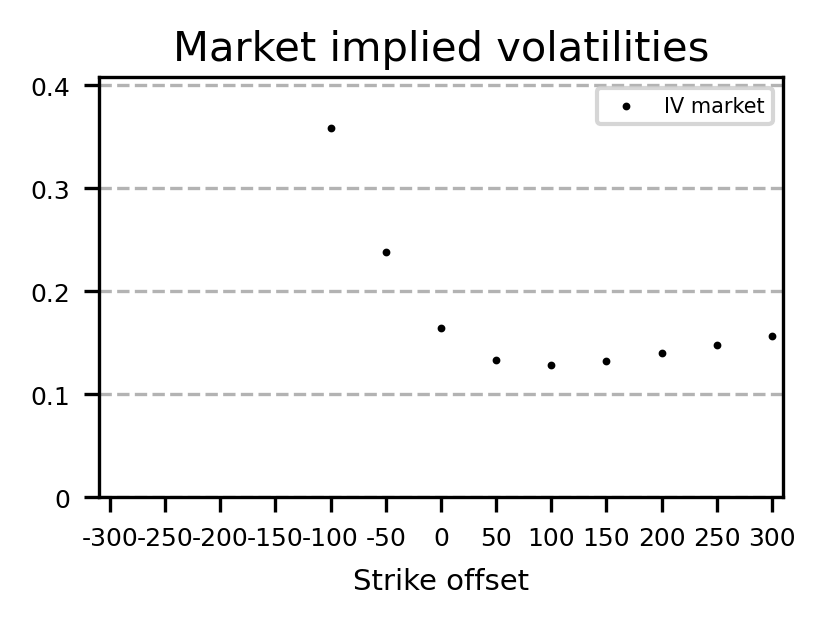

In [10]:
def fit_sabr_obj(param, sigma_market, K, T, R):
    sigma_0, beta, upsilon, rho = param
    N = len(sigma_market)
    y = 0
    for n in range(N):
        sigma_sabr = fid.sigma_sabr(K[n], T, R, sigma_0, beta, upsilon, rho, type="call")
        y += (sigma_market[n] - sigma_sabr) ** 2
    return y

M = 15
alpha = 0.5
p = np.array([1, 0.98314916, 0.96478677, 0.94539738, 0.92535353, 0.90493951, 0.88437071,
              0.86380916, 0.84337571, 0.8231596, 0.80322594, 0.78362142, 0.76437872, 0.74551992, 0.72705911])
N = 13
K_swaption_offset = [-300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 300]
price_market = np.array([0.12256859, 0.10253932, 0.08273803, 0.0633625, 0.04480655, 0.02793572,
                         0.0145331, 0.00650867, 0.0030062, 0.00158778, 0.00094974, 0.00062285, 0.00043427])
T = np.array([i * alpha for i in range(M)])
idx_exer, idx_set = 5, 12
S = 0
for i in range(idx_exer + 1, idx_set + 1):
    S += alpha * p[i]
R_swap = (p[idx_exer] - p[idx_set]) / S
print(f"2Y5Y forward par swap rate: {R_swap}")
K, iv_market = np.zeros(N), np.zeros(N)
for i in range(N):
    K[i] = R_swap + K_swaption_offset[i] / 10000
    iv_market[i] = fid.black_swaption_iv(
        price_market[i], T[idx_exer], K[i], S, R_swap, type="call", iv0=0.2,
        max_iter=2000, prec=1.0e-15)
print(f"iv_market")
print(iv_market)

# Plot of market implied volatilities
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(3, 2))
fig.suptitle(f"Market implied volatilities", fontsize=10)
gs = fig.add_gridspec(nrows=1, ncols=1, left=0.12, bottom=0.2, right=0.88, top=0.90, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0, 0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0] - 10, xticks[-1] + 10])
plt.xlabel(f"Strike offset", fontsize=7)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4], fontsize=6)
ax.set_ylim([0, 0.408])
plt.grid(axis='y', which='major', color=(0.7, 0.7, 0.7, 0), linestyle='--')
p1 = ax.scatter(K_swaption_offset, iv_market, s=3, color='black', marker=".", label="IV market")
plots = [p1]
labels = [item.get_label() for item in plots]
ax.legend(plots, labels, loc="upper right", fontsize=5)

plt.show()

That is, the 2Y5Y forward par swap rate is 0,04875 and the volatilities are plotted in the graph above. 

#### aiii) 
From the convexity appearance volatility plot it appears that the market prices are *not* consistent with our expectations from what Black's model would imply: That is, the pricing method is inconsistent with the 2Y4Y forward swap rate assuming a log-normal distribution. This chosen method implies a distribution with fatter tails and a leftward skew compared to a typical log-normal distribution.

#### bi)

In [11]:
param_0 = (0.06, 0.5, 0.45, -0.2)
result = minimize(fit_sabr_obj, param_0, method='nelder-mead', args=(iv_market, K, T[idx_exer], R_swap), options={'xatol': 1e-8, 'disp': True})
print(f"Fitted parameter values. sigma_0: {result.x[0]}, beta: {result.x[1]}, upsilon: {result.x[2]}, rho: {result.x[3]}")
sigma_0, beta, upsilon, rho = result.x

Fitted parameter values. sigma_0: 0.06, beta: 0.5, upsilon: 0.45, rho: -0.2


That is, the parameter values are fitted perfectly

#### bii)

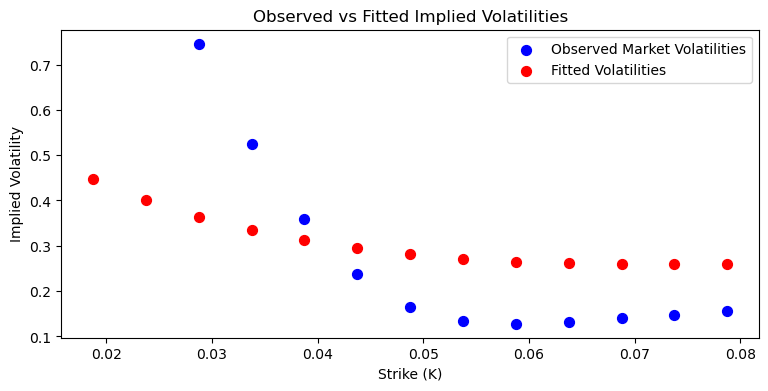

In [12]:
# Calculate Mean Squared Error
iv_fitted = np.zeros(N)
for i in range(N):
    iv_fitted[i] = fid.sigma_sabr(K[i], T[idx_exer], R_swap, 0.06, 0.5, 0.45, -0.2, type="call")

# Plotting observed and fitted volatilities
fig, ax = plt.subplots(figsize=(9, 4))

# Plot observed market volatilities
ax.scatter(K, iv_market, label='Observed Market Volatilities', color='blue', marker='o', s=50)

# Plot fitted volatilities
ax.scatter(K, iv_fitted, label='Fitted Volatilities', color='red', marker='o', s=50)

# Set labels and title
ax.set_xlabel('Strike (K)')
ax.set_ylabel('Implied Volatility')
ax.set_title('Observed vs Fitted Implied Volatilities')

# Add legend
ax.legend()

From the plot above it appears that we have a pretty poor fit between the observed and fitted implied volatilities even though the fitted parameter values would suggest a close fit. This might be due to an error in the plotting of the fitted volatilities.

#### ci) Calculating the fair value

In [21]:
M_deriv, T_deriv = 2000, 2 
N_deriv = 10000
X = np.zeros([N_deriv]) 
for n in range(0,N_deriv):
    r_simul = fid.short_rate_simul(r0,(a,b,sigma),M_deriv,T_deriv,method = "cir")
    X[n] = np.exp(-(T_deriv/M_deriv)*sum(r_simul))*max(r_simul) 
    pi = sum(X)/N_deriv
print(f"Fair value of the derivative is: {pi}")

Fair value of the derivative is: 0.0644001015966496


### Problem 4

In [22]:
M=13
alpha = 0.5 
R = 0.055
T = np.array([i*alpha for i in range(0,M)])
spot_rate = np.array([np.nan,0.0371,0.0426,0.0469,0.0502,0.0528,0.0549,0.0564,0.0577,0.0586,0.0594,0.06,0.0604]) 
sigma_caplet = np.array([np.nan,np.nan,0.182,0.205,0.229,0.255,0.283,0.313,0.347,0.381,0.423,0.484,0.545]) 

#### ai)

In [23]:
# Ensure all arrays have the same length
assert len(T) == len(spot_rate) == len(sigma_caplet), "Arrays T, spot_rate, and sigma_caplet must have the same length"

# Rest of your code
p = fid.spot_rates_to_zcb(T, spot_rate)
L = fid.zcb_to_forward_LIBOR_rates(T, p, horizon=1)
print(f"6M forward LIBOR: {L}")

6M forward LIBOR: [0.         0.03744624 0.04868307 0.05627724 0.06101212 0.06420916
 0.06648104 0.06648104 0.06792808 0.06689438 0.0677213  0.06710108
 0.06586119]


#### aii)

In order assess whether the 6-month forward EURIBOR rates already reflect the market's expectation of rising interest rates, one can look at the yield curve and observe the spread between the current 6-month rate and the 6-month forward rate:

In [24]:
print(spot_rate - L)

[        nan -0.00034624 -0.00608307 -0.00937724 -0.01081212 -0.01140916
 -0.01158104 -0.01008104 -0.01022808 -0.00829438 -0.0083213  -0.00710108
 -0.00546119]


Since it appears that the 6-month forward rate is strictly higher than the current rate, it suggests that the market anticipates rising interest rates. Given that the market expects rising interest rates in the future this will increase the demand for hedging and thereby increase the cost of the client to protect himself. 

#### bii)

In [25]:
alpha = 0.5
M = 13
T = np.array([i * alpha for i in range(0, M)])
idx_n, idx_N = 3, 6
S_swap = 0

for idx in range(idx_n + 1, idx_N + 1):
    S_swap += alpha * p[idx]

R_swap = (p[idx_n] - p[idx_N]) / S_swap
print(f"Par swap rate: {R_swap}")

# Optimization
param_0 = 0.05  # Initial guess for the forward rate
result = minimize(fid.fit_vasicek_obj, param_0, method='nelder-mead', args=(R_swap, T), options={'xatol': 1e-20, 'disp': True})

forward_rate_3Y3Y = result.x[0]
print(f"3Y3Y Forward Par Swap Rate: {forward_rate_3Y3Y}")

Par swap rate: 0.06384218857096323


ValueError: not enough values to unpack (expected 4, got 1)

#### ci)

The a potential upside of the interest rate cap is that If the market interest rate doesn't exceed the strike price, the cap doesn't come into play. In this scenario, the client pays the floating rate, which potentially could be lower than the strike price if rates fall. This means they benefit from the lower rates and avoid the cap premium. However, the potential downside regardless of the market rate, is that the client has already paid the upfront premium for the cap. This sunk cost essentially creates a "floor" below which their effective interest expense cannot fall, limiting the overall benefit from significantly declining rates.  


The upside to the forward payer swaption is that it if offer a fixed interest rate regardless of future market fluctuations. Entering into a swaption typically involves an upfront premium payment. The downside to this that the initial cost reduces the potential benefit if floating rates remain low or even decline.

#### cii)

None of the agreement can provide the client with perfect interest rate protection. There is no single financial instrument that offers complete protection against rising interest rates. However, one can combine strategies to get closer to complete protection: By buying a 3Y3Y payer swaption and an interest rate cap with a strike slightly above the expected future fixed rate (e.g., 0.06), the client can limit the potential losses arising from both rising fixed and floating rates. This strategy would be closest to full protection, but it comes at a cost. The client would need to pay premiums for both the swaption and the cap, increasing the overall cost of hedging. Depending on the clients individual risk aversion towards interest rate fluctuaction he might decide that a stronger hedging is worth the premium. 